In [16]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy
from arpes.utilities.conversion import convert_coordinates

import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Core #
import json
import os
import re

# IO
import h5py

# Science And Plotting #
import matplotlib
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import holoviews as hv
import holoviews.util
hv.extension('matplotlib')

sns.set()

from scipy import optimize

# Analysis #
import arpes
import arpes.config
from arpes.models.spectrum import DLD_Spectrum_factory, load_SES
from arpes.models.view import View

# Jupyter #
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# Configure Jupyter #
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<script src="https://code.jquery.com/ui/1.10.4/jquery-ui.min.js" type="text/javascript"></script>
<script type="text/javascript">function HoloViewsWidget(){
}

HoloViewsWidget.comms = {};
HoloViewsWidget.comm_state = {};

HoloViewsWidget.prototype.init_slider = function(init_val){
	if(this.load_json) {
		this.from_json()
	} else {
		this.update_cache();
	}
}

HoloViewsWidget.prototype.populate_cache = function(idx){
    this.cache[idx].html(this.frames[idx]);
    if (this.embed) {
        delete this.frames[idx];
    }
}

HoloViewsWidget.prototype.process_error = function(msg){

}

HoloViewsWidget.prototype.from_json = function() {
	var data_url = this.json_path + this.id + '.json';
	$.getJSON(data_url, $.proxy(function(json_data) {
		this.frames = json_data;
		this.update_cache();
		this.update(0);
	}, this));
}

HoloViewsWidget.prototype.dynamic_update = function(current){
	if (current === undefined) {
		return
	}
	if(this.dynamic) {
		current = JSON.stringify(current);
	}
	function callback(initialized, msg){
		/* This callback receives data from Python as a string
		   in order to parse it correctly quotes are sliced off*/
		if (msg.content.ename != undefined) {
			this.process_error(msg);
		}
		if (msg.msg_type != "execute_result") {
			console.log("Warning: HoloViews callback returned unexpected data for key: (", current, ") with the following content:", msg.content)
			this.time = undefined;
			this.wait = false;
			return
		}
		this.timed = (Date.now() - this.time) * 1.1;
		if (msg.msg_type == "execute_result") {
			if (msg.content.data['text/plain'].includes('Complete')) {
				this.wait = false;
				if (this.queue.length > 0) {
					this.time = Date.now();
					this.dynamic_update(this.queue[this.queue.length-1]);
					this.queue = [];
				}
				return
			}
		}
	}
	this.current = current;
	if ((window.Jupyter !== undefined) && (Jupyter.notebook.kernel != null)) {
		var kernel = Jupyter.notebook.kernel;
		callbacks = {iopub: {output: $.proxy(callback, this, this.initialized)}};
		var cmd = "holoviews.plotting.widgets.NdWidget.widgets['" + this.id + "'].update(" + current + ")";
		kernel.execute("import holoviews;" + cmd, callbacks, {silent : false});
	}
}

HoloViewsWidget.prototype.update_cache = function(force){
    var frame_len = Object.keys(this.frames).length;
    for (var i=0; i<frame_len; i++) {
        if(!this.load_json || this.dynamic)  {
            frame = Object.keys(this.frames)[i];
        } else {
            frame = i;
        }
        if(!(frame in this.cache) || force) {
			if ((frame in this.cache) && force) { this.cache[frame].remove() }
			this.cache[frame] = $('<div />').appendTo("#"+"_anim_img"+this.id).hide();
			var cache_id = "_anim_img"+this.id+"_"+frame;
			this.cache[frame].attr("id", cache_id);
			this.populate_cache(frame);
        }
    }
}

HoloViewsWidget.prototype.update = function(current){
    if(current in this.cache) {
        $.each(this.cache, function(index, value) {
            value.hide();
        });
        this.cache[current].show();
		this.wait = false;
    }
}

HoloViewsWidget.prototype.init_comms = function() {
	if ((window.Jupyter !== undefined) && (Jupyter.notebook.kernel !== undefined)) {
		var widget = this;
		comm_manager = Jupyter.notebook.kernel.comm_manager;
        comm_manager.register_target(this.id, function (comm) {
			comm.on_msg(function (msg) { widget.process_msg(msg) });
		});
	}
}

HoloViewsWidget.prototype.process_msg = function(msg) {
}

function SelectionWidget(frames, id, slider_ids, keyMap, dim_vals, notFound, load_json, mode, cached, json_path, dynamic){
    this.frames = frames;
    this.id = id;
    this.slider_ids = slider_ids;
    this.keyMap = keyMap
    this.current_frame = 0;
    this.current_vals = dim_vals;
    this.load_json = load_json;
    this.mode = mode;
    this.notFound = notFound;
    this.cached = cached;
    this.dynamic = dynamic;
    this.cache = {};
	this.json_path = json_path;
    this.init_slider(this.current_vals[0]);

In [5]:
data = xr.DataArray(
    np.linspace(0, 5, 20),
    {'x': np.linspace(0, 5, 20)},
    ['x']
) 

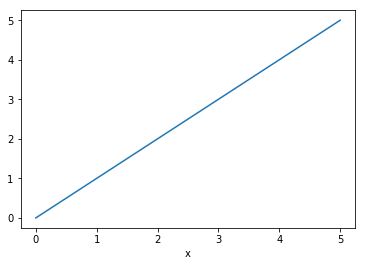

In [9]:
data.plot()

In [28]:
converted = convert_coordinates(
    data,
    {'y': np.linspace(0, np.sqrt(6), 100)},
    {
        'dims': ['y'],
        'transforms': {
            'y': lambda y: y ** 2,
        }
    }
)

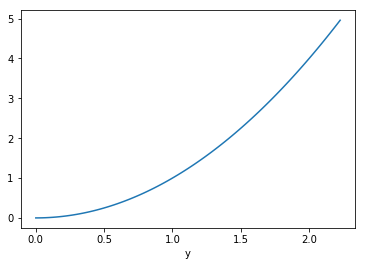

In [31]:
converted.plot()

In [172]:
full_metadata = None
with open(os.path.join(arpes.config.SOURCE_PATH, 'datasets/RhSn2/RhSn_June.json')) as metadata_file:
    full_metadata = json.load(metadata_file)

In [173]:
RhSnMap = load_SES(full_metadata[0])

In [176]:
RhSnMap.raw.attrs['provenance']

{'file': '/Users/chstansbury/Research/lanzara/data/RhSn2/hdf5/RhSn_005.h5',
 'parents_provenance': 'filesystem',
 'record': {'by': 'load_SES', 'what': 'Loaded SES dataset from HDF5.'}}

In [189]:
from arpes.corrections import apply_quadratic_fermi_edge_correction
corrected = apply_quadratic_fermi_edge_correction(RhSnMap.raw)

0 1


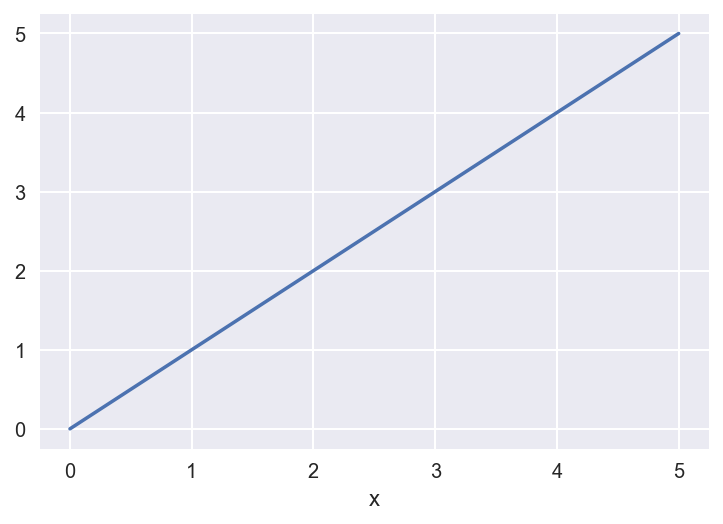

In [136]:
data.plot()

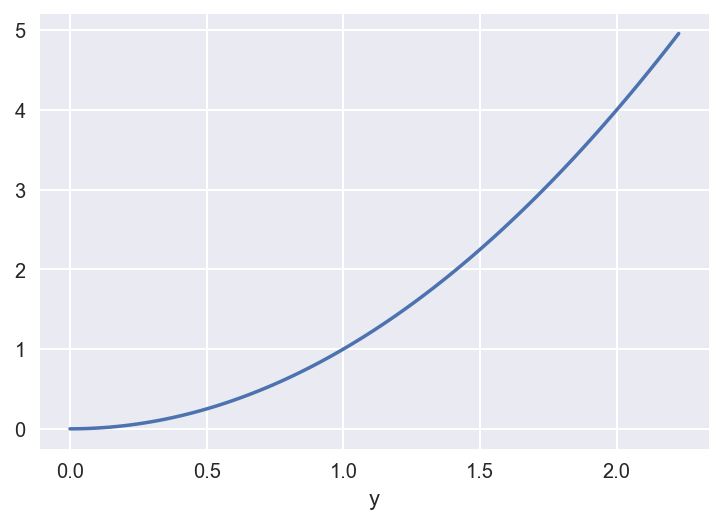

In [135]:
converted = convert_coordinates(
    data,
    {'y': np.linspace(0, np.sqrt(6), 100)},
    {
        'dims': ['y'],
        'transforms': {
            'x': lambda y: y ** 2,
        }
    }
)

converted.plot()

In [145]:
from arpes.utilities.conversion import calculate_kx_ky_bounds
(kx_low, kx_high), (ky_low, ky_high) = calculate_kx_ky_bounds(corrected)
print(calculate_kx_ky_bounds(corrected))

((-1.78, 1.4299999999999999), (-1.01, 2.5))


In [155]:
from arpes.utilities.conversion import ConvertKxKy
convert_util = ConvertKxKy(corrected)

k_converted = convert_coordinates(
    corrected,
    {'kx': np.arange(kx_low - 0.1, kx_high + 0.1, 0.02),
     'ky': np.arange(ky_low - 0.1, ky_high + 0.1, 0.02),
     'eV': corrected.coords['eV']},
    {
        'dims': ['eV', 'kx', 'ky'],
        'transforms': {
            'eV': convert_util.kspace_to_BE,
            'phi': convert_util.kspace_to_phi,
            'polar': convert_util.kspace_to_polar,
        },
    }
)

In [123]:
from arpes.utilities import rename_standard_attrs
corrected = rename_standard_attrs(corrected)

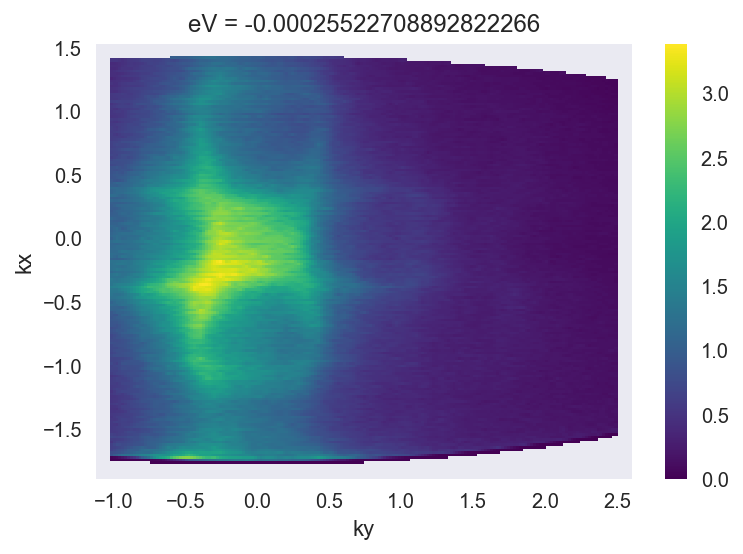

In [165]:
k_converted.sel(eV=0, method='nearest').plot()

In [169]:
from arpes.preparation import normalize_dim
normed = normalize_dim(k_converted, 'ky')

KeyError: 'id'